In [142]:
# %pip install nptyping

In [143]:
# %pip install transformers

In [144]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, Dataset
import numpy as np
from nptyping import Float32, NDArray, Number, Shape, UInt
from transformers import ViTModel
import pytorch_lightning as pl
import matplotlib.pyplot as plt


import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

In [145]:
class SignedDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [146]:
class ViT_FeatureExtractor(pl.LightningModule):
	def __init__(
		self,
		nb_classes: int = 10,
	):
		super().__init__()
		# print("---VIT INIT---")

		self.pretrained_vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
		self.pretrained_vit.eval()

		self.conv_1d_1 = torch.nn.Conv1d(
			in_channels=197,
			out_channels=64,
			kernel_size=3,
		)
		self.layer_1_relu = nn.ReLU()
		self.conv_1d_2 = torch.nn.Conv1d(
			in_channels=64,
			out_channels=nb_classes, # <-- i/o 1
			kernel_size=3,
		)
		self.layer_2_relu = nn.ReLU()

	def vit_extract_features(self, x):
		# print("---VIT EXTRACT FEATURES---")
		with torch.no_grad():
			outputs = self.pretrained_vit(pixel_values=x)
			vit_feat = outputs.last_hidden_state
			print(f"{vit_feat.shape= }")
			vit_feat = torch.flatten(vit_feat, start_dim=1)
		return vit_feat
	
	def forward(
		self,
		vit_feat, 
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print("---VIT FORWARD---")
		x = self.conv_1d_1(vit_feat)
		x = self.layer_1_relu(x)
		x = self.conv_1d_2(x)
		x = self.layer_2_relu(x)
		return x

In [147]:
class BasicModel(pl.LightningModule):
	def __init__(
		self,
	):
		# print("---BASIC MODEL INIT---")
		super().__init__()
		self.save_hyperparameters()

		self.vocabulary_size = nb_classes
		self.layer = nn.Linear(151296, self.vocabulary_size)
		self.softmax = torch.nn.Softmax(dim=2)

	def forward(
		self, x: NDArray[Shape["* batch, 224, 224, 3"], Float32]
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		# print("---BASIC MODEL FORWARD---")
		x = self.layer(x)
		x = self.softmax(x)
		return x

In [148]:
class GRU_Translator(pl.LightningModule):
	def __init__(
		self,
		nb_classes,
		H_input_size: int = 151296,
		H_output_size: int = 10,
		num_layers: int = 1,
		dropout: int = 0,
	):
		# print("---GRU INIT---")
		super().__init__()
		self.save_hyperparameters()
		self.vocabulary_size = nb_classes
		self.layer_gru = nn.GRU(
			input_size=self.hparams.H_input_size,
			hidden_size=self.hparams.nb_classes,
			num_layers=self.hparams.num_layers,
			batch_first=True,
			dropout=self.hparams.dropout,
		)
		
		# self.layer_1_dense = nn.Linear(self.hparams.H_output_size, self.hparams.H_output_size)
		# self.layer_1_relu = nn.ReLU()
		# self.layer_2_dense = nn.Linear(self.hparams.H_output_size, self.vocabulary_size)
		# self.layer_2_relu = nn.ReLU()
		self.softmax = nn.Softmax(dim=2) # <-- i/o dim=2

	def forward(self, X):
		# print("---GRU FORWARD---")	
		# print(f'{X.shape =}')
		X, _ = self.layer_gru(X)
		# X = self.layer_1_dense(X)
		# X = self.layer_1_relu(X)
		# X = self.layer_2_dense(X)
		# X = self.layer_2_relu(X)
		# print(f'{X.shape =}')
		X = self.softmax(X)
		# print(f'{X.shape =}')
		return X


In [149]:

class BaseSquareNet(pl.LightningModule):
	def __init__(
		self,
		batch_size: int = 1,
		seq_size: int = 1,
		nb_classes: int = 10,
		h_in: int = 10,
	):
		super().__init__()
		self.save_hyperparameters()

		self.batch_size = batch_size
		self.nb_seq_sizebatch = seq_size
		self.image_feature_extractr = ViT_FeatureExtractor(nb_classes=nb_classes)
		self.recurrent_translator = GRU_Translator(
			nb_classes = nb_classes,
			H_input_size=h_in,
			# H_output_size=100,
			num_layers=1,
			dropout=0,
		)

	def forward(
		self, x: NDArray[Shape["* batch, 224, 224, 3"], Float32]
	) -> NDArray[Shape["* batch, * vocab size"], Float32]:
		x = self.recurrent_translator(x)
		return x

In [150]:
# Hyperparameters
nb_classes=4
seq_size = 3
batch_size = 2
learning_rate = 1e-2
h_in = 4

In [151]:
# Data
# x = torch.rand((batch_size, seq_size, 3, 224, 224))
# y = torch.randint(0, nb_classes, (batch_size, seq_size, 1))

# x = torch.rand((batch_size, 3, 224, 224))
x = torch.rand((batch_size, seq_size, h_in))
y = torch.randint(0, nb_classes, (batch_size, seq_size))

print(f"{x = }")
print(f"{y = }")

x = tensor([[[0.2944, 0.8329, 0.2588, 0.7053],
         [0.8843, 0.9629, 0.2389, 0.9053],
         [0.7545, 0.6180, 0.1006, 0.4323]],

        [[0.1160, 0.5429, 0.0904, 0.1689],
         [0.0845, 0.7115, 0.4309, 0.3320],
         [0.4815, 0.7264, 0.6054, 0.1431]]])
y = tensor([[0, 2, 1],
        [1, 3, 1]])


In [152]:
from tqdm import tqdm 

# Models
# vit_feat = model.image_feature_extractr.vit_extract_features(x)

# dataset = SignedDataset(vit_feat, y)
dataset = SignedDataset(x, y)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size)
	# lr = 10 ** (- e_lr / 10)

loss_fn = torch.nn.CrossEntropyLoss()


def train(train_loader, model, loss_fn, learning_rate, epochs=100):
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	losses = []
	idx = 0
	for epoch in tqdm(range(epochs)):
		for batch_idx, (X, y) in enumerate(train_loader):
			pred = model(X)
			pred = pred.permute(0, 2, 1)
			loss = loss_fn(pred, y)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			# if epoch % 10 == 0:
			# 	print(f'[{epoch = }] loss: {loss}')
			idx += 1
			losses.append(float(loss.detach().numpy()))
	return losses

100%|██████████| 1000/1000 [00:00<00:00, 1087.61it/s]


For lr = 0.01, min(losses) = 1.1477824449539185


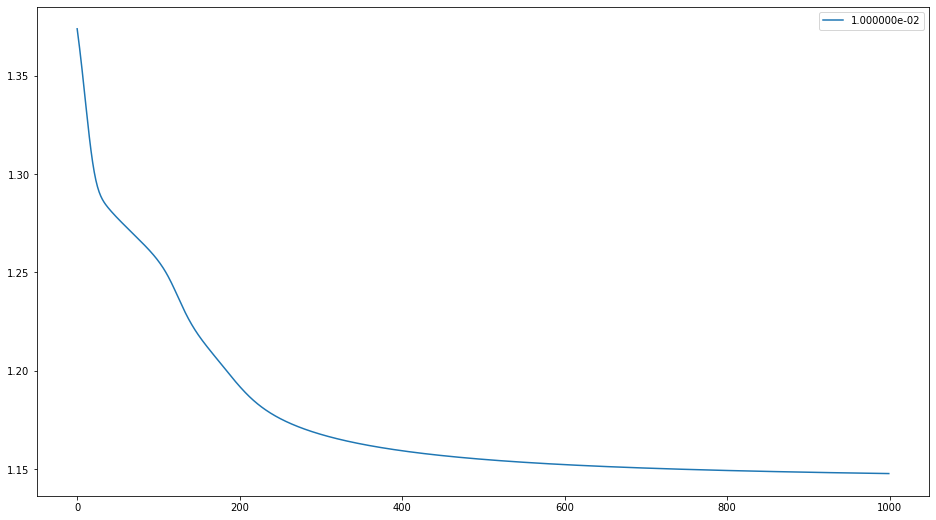

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
torch.manual_seed(6)

for lr in [0.01]:
	# lr = 10 ** (- e_lr / 10)
	model = BaseSquareNet(nb_classes=nb_classes, seq_size=seq_size, batch_size=batch_size, h_in=h_in)
	losses = train(dataloader, model, loss_fn, learning_rate=lr, epochs=int(1e3))
	print(f"For {lr = }, {min(losses) = }")
	plt.plot(losses, label=f"{lr:e}")
leg = plt.legend(loc='best')
plt.show()